In [68]:
import jax
import jax.numpy as jnp
from jax.example_libraries import stax, optimizers
from jax import random, value_and_grad, debug
import matplotlib.pyplot as plt

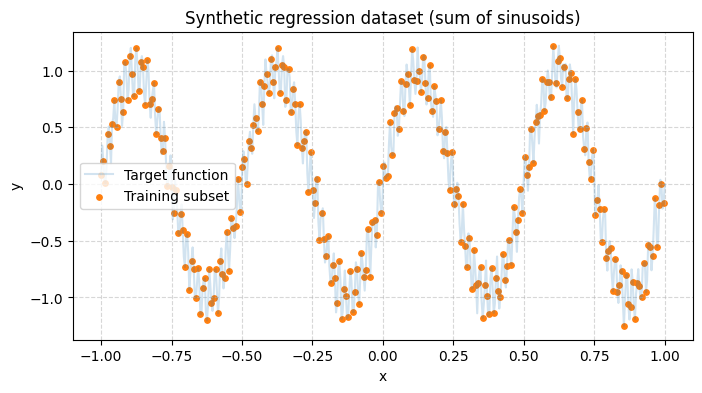

In [115]:
# -----------------------------
# 1. Generate data
# -----------------------------
key = random.PRNGKey(0)
x = jnp.linspace(-1.0, 1.0, 512).reshape(-1, 1)

# target function (sum of sinusoids)
low = jnp.sin(4 * jnp.pi * x)
high = 0.2 * jnp.sin(100 * jnp.pi * x)
noise = 0.05 * jax.random.normal(key, x.shape)

y = low + high + noise   # shape [N,1]

# train/test split
X_train, y_train = x[0::2], y[0::2]
X_test,  y_test  = x[1::2], y[1::2]

# visualize full dataset
plt.figure(figsize=(8, 4))
plt.plot(x, y, label='Target function', color='C0', alpha=0.2)
plt.scatter(X_train, y_train, color='C1', s=15, alpha=1, label='Training subset')
plt.title("Synthetic regression dataset (sum of sinusoids)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, ls='--', alpha=0.5)
plt.show()

In [119]:
# -----------------------------
# 2. Define MLP
# -----------------------------
init_fn, apply_fn = stax.serial(
    stax.Dense(2048), stax.Relu,
    stax.Dense(1)
)
_, params = init_fn(key, X_train.shape)

apply_fn = jax.jit(apply_fn)

# -----------------------------
# 3. Loss + optimizer
# -----------------------------
def loss_fn(p, x, y):
    preds = apply_fn(p, x)          # [N,1]
    return jnp.mean((preds - y) ** 2)

opt_init, opt_update, get_params = optimizers.adam(1e-3)
opt_state = opt_init(params)

@jax.jit
def train_step(opt_state, x, y, step):
    params = get_params(opt_state)
    loss, grads = value_and_grad(loss_fn)(params, x, y)
    opt_state = opt_update(step, grads, opt_state)  
    return opt_state, loss

In [120]:
# -----------------------------
# 4. Training loop
# -----------------------------
num_steps = 10000
log_every = 500
loss_history = []

for step in range(1, num_steps + 1):
    opt_state, loss = train_step(opt_state, X_train, y_train, step)
    loss_history.append(loss)
    if step % log_every == 0 or step == 1:
        p = get_params(opt_state)
        tr = loss_fn(p, X_train, y_train)
        te = loss_fn(p, X_test, y_test)
        print(f"Step {step:4d} | Train MSE = {tr:.6f} | Test MSE = {te:.6f}")

Step    1 | Train MSE = 0.505895 | Test MSE = 0.499194
Step  500 | Train MSE = 0.098276 | Test MSE = 0.097130
Step 1000 | Train MSE = 0.089712 | Test MSE = 0.089558
Step 1500 | Train MSE = 0.081936 | Test MSE = 0.081321
Step 2000 | Train MSE = 0.072111 | Test MSE = 0.072346
Step 2500 | Train MSE = 0.063498 | Test MSE = 0.063769
Step 3000 | Train MSE = 0.056238 | Test MSE = 0.056461
Step 3500 | Train MSE = 0.050377 | Test MSE = 0.050434
Step 4000 | Train MSE = 0.045943 | Test MSE = 0.045850
Step 4500 | Train MSE = 0.042359 | Test MSE = 0.042698
Step 5000 | Train MSE = 0.039391 | Test MSE = 0.039855
Step 5500 | Train MSE = 0.036559 | Test MSE = 0.036626
Step 6000 | Train MSE = 0.034780 | Test MSE = 0.035173
Step 6500 | Train MSE = 0.033028 | Test MSE = 0.033320
Step 7000 | Train MSE = 0.031830 | Test MSE = 0.032161
Step 7500 | Train MSE = 0.030831 | Test MSE = 0.030876
Step 8000 | Train MSE = 0.029751 | Test MSE = 0.029986
Step 8500 | Train MSE = 0.029290 | Test MSE = 0.029411
Step 9000 

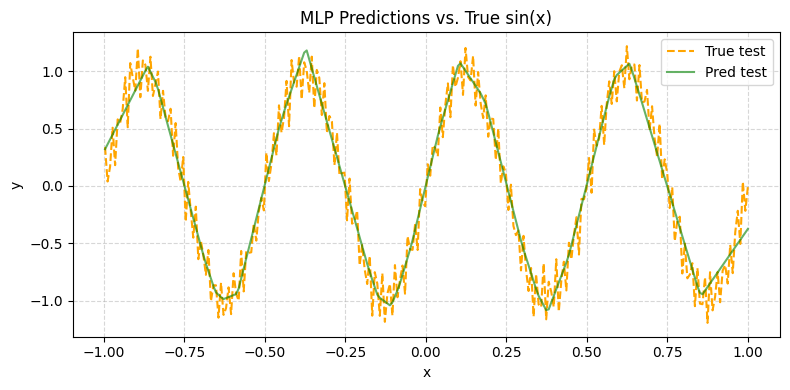

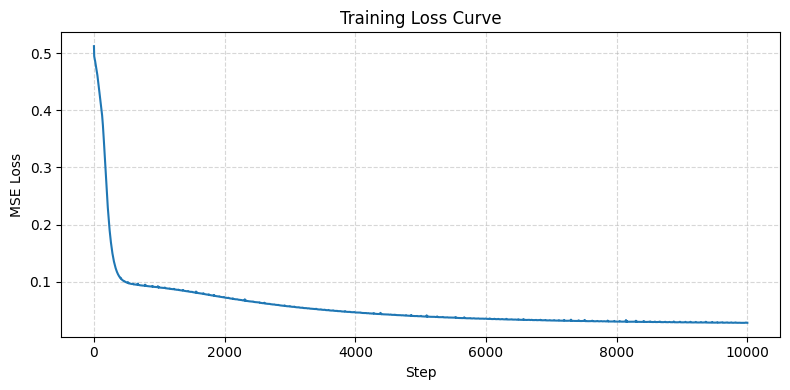

In [121]:
# -----------------------------
# 5. Plot results
# -----------------------------
params = get_params(opt_state)
y_pred_train = apply_fn(params, X_train)
y_pred_test = apply_fn(params, X_test)

# -----------------------------
# Plot 1: Predictions
# -----------------------------
plt.figure(figsize=(8, 4))
# plt.plot(X_train, y_train, label="True train", color="blue")
plt.plot(X_test, y_test, label="True test", color="orange", linestyle="--")
# plt.plot(X_train, y_pred_train, label="Pred train", color="red", alpha=0.6)
plt.plot(X_test, y_pred_test, label="Pred test", color="green", alpha=0.6)
plt.title("MLP Predictions vs. True sin(x)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="upper right")
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()


# -----------------------------
# Plot 2: Training loss curve
# -----------------------------
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.title("Training Loss Curve")
plt.xlabel("Step")
plt.ylabel("MSE Loss")
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()